<a href="https://colab.research.google.com/github/ianog88/Asset_Pricing/blob/main/Asset_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.stats import johnsonsu
from scipy.fft import fft, ifft
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
df = pd.read_csv('Cross_section.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AAP,AES,...,WHR,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
0,-0.001161,-0.015632,0.038066,-0.008257,-0.003620,-0.008022,-0.015389,0.003939,0.000000,-0.005455,...,-0.002519,-0.007640,0.010216,0.010756,-0.002922,-0.003273,0.006254,0.000977,0.014328,0.001364
1,0.007394,0.010849,-0.006011,-0.012633,0.005523,0.027426,0.010066,0.008871,0.015588,0.023766,...,-0.008513,0.010956,-0.000289,0.012066,0.003663,-0.001459,0.010950,-0.008049,0.005097,0.028610
2,0.001258,-0.011044,0.008165,0.002035,-0.004336,-0.041410,-0.004983,-0.003889,-0.003396,-0.031250,...,-0.015284,-0.004394,-0.002890,0.003395,-0.010584,-0.013153,-0.006294,0.005655,0.002463,-0.004856
3,0.000105,0.019031,0.000300,-0.021764,0.005806,0.011782,0.005272,0.005772,-0.016356,0.000000,...,0.006132,-0.012357,-0.004928,-0.000825,0.001844,-0.012218,-0.041980,0.000733,0.001445,-0.019965
4,0.009529,-0.006482,0.006597,0.005636,0.007072,0.004940,0.013634,-0.002532,0.003048,0.004608,...,0.007618,0.005958,-0.000291,0.003551,0.001473,0.015742,-0.003383,0.010750,0.018473,-0.010865


In [3]:
X = df
X = X.to_numpy()
X_tensor = torch.FloatTensor(X)

# Train Autoencoder

In [4]:
class Autoencoder(nn.Module):
   def __init__(self, input_size, encoding_dim):
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential(
           nn.Linear(input_size, 32),
           nn.ReLU(),
           nn.Linear(32, 16),
           nn.ReLU(),
           nn.Linear(16, encoding_dim),
       )
       self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, 16),
           nn.ReLU(),
           nn.Linear(16, 32),
           nn.ReLU(),
           nn.Linear(32, input_size),
       )

   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
       return x

In [5]:
torch.manual_seed(42)

input_size = X.shape[1]
encoding_dim = 4
model = Autoencoder(input_size, encoding_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

for e in range(400):
   outputs = model(X_tensor)
   loss = criterion(outputs, X_tensor)

   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

encoded_data = model.encoder(X_tensor).detach().numpy()

In [6]:
latent_df = pd.DataFrame()

for i in range(2516):
  sample = X[i]
  sample_tensor = torch.FloatTensor(sample)
  output_data = model.encoder(sample_tensor).detach().numpy()
  latent_df[i] = (output_data).tolist()

latent_df = latent_df.T

<ipython-input-6-c190f51733d4>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  latent_df[i] = (output_data).tolist()


In [7]:
latent_df.head()

,0,1,2,3
0,-0.067917,0.061840,0.167389,0.098762
1,-0.019733,0.051911,0.183358,0.143826
2,-0.079800,0.057037,0.157413,0.087529
3,-0.088973,0.079549,0.170134,0.076597
4,-0.030532,0.062499,0.148807,0.146567


## Latent Variables appear relatively stationary

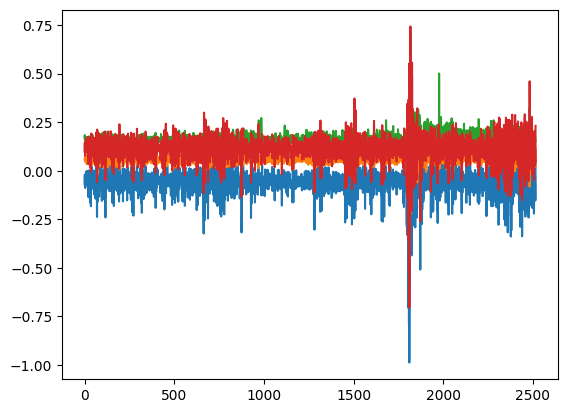

In [8]:
plt.plot(latent_df[0])
plt.plot(latent_df[1])
plt.plot(latent_df[2])
plt.plot(latent_df[3]);

## Factors are unimodal but not normally distributed, hence the use of the Johnson SU distribution

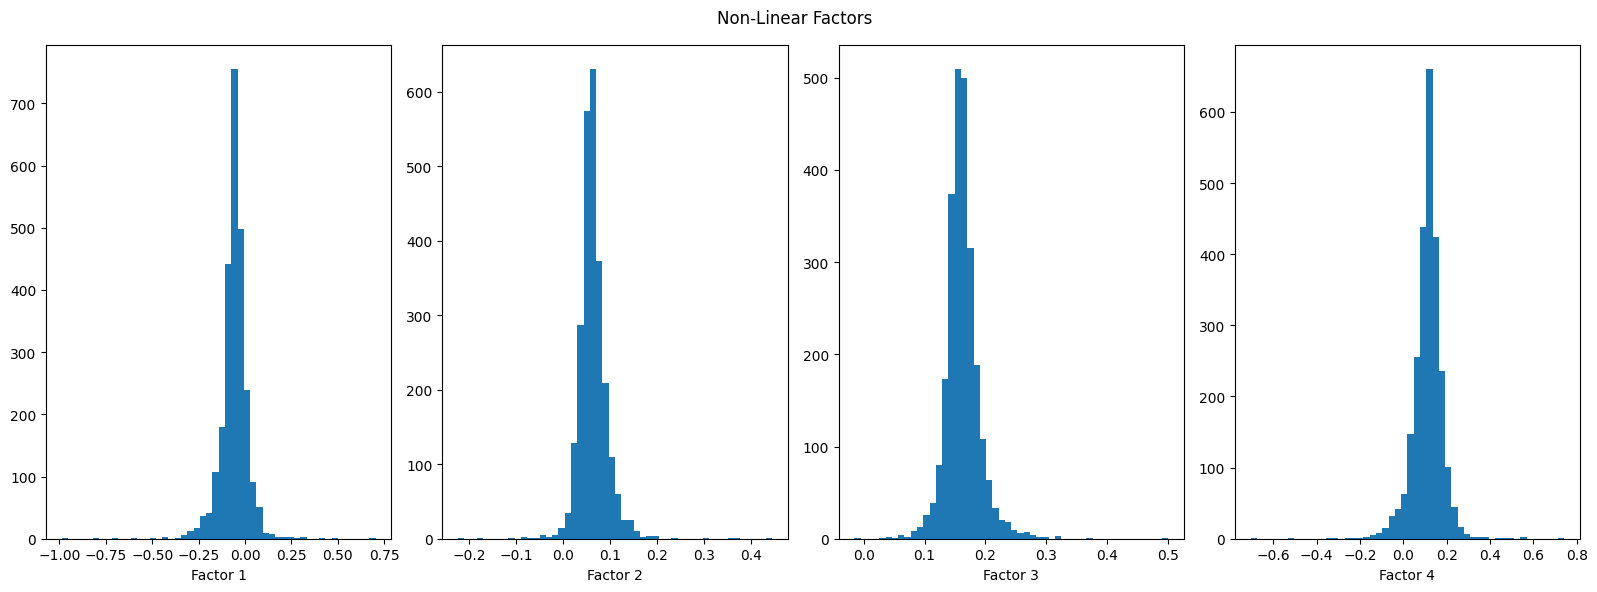

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,6))

fig.suptitle("Non-Linear Factors")

axes[0].hist(latent_df[0], bins=50)
axes[0].set_xlabel("Factor 1")

axes[1].hist(latent_df[1], bins=50)
axes[1].set_xlabel("Factor 2")

axes[2].hist(latent_df[2], bins=50)
axes[2].set_xlabel("Factor 3")

axes[3].hist(latent_df[3], bins=50)
axes[3].set_xlabel("Factor 4")
plt.tight_layout();

In [10]:
params1 = johnsonsu.fit(latent_df[0])
params2 = johnsonsu.fit(latent_df[1])
params3 = johnsonsu.fit(latent_df[2])
params4 = johnsonsu.fit(latent_df[3])

In [11]:
x_min, x_max = -1, 0.6
grid = np.linspace(x_min, x_max, 1000)

# Train network to predict factor loadings based off the stocks recent price data

In [12]:
data = pd.read_csv('auto_dataset.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.001917,0.032117,-0.011390,-0.018599,-0.004297,-0.002774,-0.007109,0.005604,0.004876,0.001617,...,0.002253,0.009224,-0.014055,-0.000467,0.014184,-0.009375,0.024979,0.006660,0.007067,0.001269
1,0.021335,-0.022118,-0.006786,0.010627,-0.005759,-0.023168,-0.016241,0.009958,-0.005708,-0.002349,...,-0.002935,-0.015253,0.017391,-0.001870,-0.008028,0.002428,0.009688,0.009062,-0.019282,0.016698
2,0.013331,-0.001943,-0.008838,-0.018135,-0.008927,0.004659,-0.008038,0.012623,0.018006,-0.019048,...,0.002326,-0.019644,0.003787,0.010689,-0.004666,0.012500,0.000000,0.015123,0.045759,-0.045355
3,-0.020698,0.007712,0.003968,0.005364,-0.002415,0.017846,0.016427,-0.014094,0.018379,0.000325,...,0.024659,-0.013880,0.007760,0.014339,-0.011989,0.004027,-0.006017,0.012531,0.012638,0.009218
4,0.002557,-0.010900,0.009439,-0.011452,-0.011460,-0.005902,-0.015308,0.008096,-0.009227,-0.016988,...,0.014506,-0.007282,0.028807,0.007087,0.012779,-0.000128,0.002771,-0.002466,0.013894,0.026651


In [13]:
X = data.drop(['20'], axis=1)
y = data['20']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## The network takes in the past 20 days of price data and outputs four factor loadings

In [14]:
class JohnsonSUNet(nn.Module):
    def __init__(self):
        super(JohnsonSUNet, self).__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        params = self.fc2(x)
        gamma = params[:, 0]
        delta = torch.nn.functional.softplus(params[:, 1])
        xi = params[:, 2]
        lambd = torch.nn.functional.softplus(params[:, 3])
        return torch.stack((gamma, delta, xi, lambd), dim=1)

## The loss functions takes in the parameters of the distribution and the target value and computes the loss via negative log likelihood

In [15]:
def johnsonsu_nll_loss(output, target):
    gamma, delta, xi, lambd = output[:, 0], output[:, 1], output[:, 2], output[:, 3]
    nll = -torch.log(torch.tensor([
        johnsonsu.pdf(t.item(), a=gamma[i].item(), b=delta[i].item(), loc=xi[i].item(), scale=lambd[i].item())
        for i, t in enumerate(target)
    ]))
    return nll.mean()

### This function multilpies our factor loadings by the location and scale parameters, the loadings do not have an effect on the skew and tail weight

In [16]:
def pdf(variable, output, params, index):
    output_value = output[index]
    return johnsonsu.pdf(variable, a=params[0], b=params[1], loc=params[2]*output_value, scale=params[3]*output_value)

### This function calculates the sum of the four distributions by convolving the probability density functions of the latent variables multilpied by the factor loadings. It performs the convolution using the Fast Fourier Transform which significantly reduces the computational complexity

In [17]:
def convolved(output_tensor, grid, params1, params2, params3, params4):
    batch_size = output_tensor.shape[0]
    final_params_list = []

    for i in range(batch_size):
        output = output_tensor[i]

        pdf_1 = pdf(grid, output, params1, 0)
        pdf_2 = pdf(grid, output, params2, 1)
        pdf_3 = pdf(grid, output, params3, 2)
        pdf_4 = pdf(grid, output, params4, 3)

        fft_pdf_1 = fft(pdf_1)
        fft_pdf_2 = fft(pdf_2)
        fft_pdf_3 = fft(pdf_3)
        fft_pdf_4 = fft(pdf_4)

        fft_convolution = fft_pdf_1 * fft_pdf_2 * fft_pdf_3 * fft_pdf_4
        pdf_convolved = ifft(fft_convolution).real
        pdf_convolved /= np.trapz(pdf_convolved, grid)

        if np.isnan(pdf_convolved).any():
            pdf_convolved = np.nan_to_num(pdf_convolved)

        final_params = johnsonsu.fit(pdf_convolved)
        final_params_list.append(final_params)

    final_params_batch = np.array(final_params_list)
    return final_params_batch

## Training Loop

In [20]:
num_epochs = 1000

inputs = X_train.values
inputs = torch.FloatTensor(inputs)
targets = y_train.values
targets = torch.FloatTensor(targets)

model = JohnsonSUNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()

    outputs = model(inputs)
    output_tensor = outputs.detach().numpy()

    final_params_batch = convolved(output_tensor, grid, params1, params2, params3, params4)

    loss = johnsonsu_nll_loss(final_params_batch, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### The model produces a test set CRPS of 1.31, which is a strong initial result given the fact that we were using static latent variable parameters and only recent price data

In [21]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    predictions = predictions.detach().numpy()
    predictions = convolved(predictions, grid, params1, params2, params3, params4)

def crps_johnson_su(y, gamma, delta, xi, lambd):
    def integrand(x):
        cdf_val = johnsonsu.cdf(x, a=gamma, b=delta, loc=xi, scale=lambd)
        return (cdf_val - (x >= y)) ** 2

    integral, _ = quad(integrand, -np.inf, np.inf)
    return integral

crps_scores = []
for i in range(len(X_test)):
    gamma, delta, xi, lambd = predictions[i]
    target = y_test[i].item()
    crps = crps_johnson_su(y_test, gamma.item(), delta.item(), xi.item(), lambd.item())
    crps_scores.append(crps)

average_crps = np.mean(crps_scores)
print(f'Average CRPS: {average_crps}')

Average CRPS: 1.31
